# Lesson 3

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as np
import sys
import matplotlib

%matplotlib inline

We will be creating our own test data for analysis.

In [2]:
# set seed
np.seed(111)

# Function to generate test data
def CreateDataSet(Number=1):
    
    Output = []
    
    for i in range(Number):
        
        # Create a weekly (mondays) date range
        rng = pd.date_range(start='1/1/2009', end='12/31/2012', freq='W-MON')
        
        # Create random data
        data = np.randint(low=25,high=1000,size=len(rng))
        
        # Status pool
        status = [1,2,3]
        
        # Make a random list of statuses
        random_status = [status[np.randint(low=0,high=len(status))] for i in range(len(rng))]
        
        # State pool
        states = ['GA','FL','fl','NY','NJ','TX']
        
        # Make a random list of states 
        random_states = [states[np.randint(low=0,high=len(states))] for i in range(len(rng))]
    
        Output.extend(zip(random_states, random_status, data, rng))
        
    return Output

In [3]:
dataset = CreateDataSet(4)
df = pd.DataFrame(data=dataset, columns=['State','Status','CustomerCount','StatusDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836 entries, 0 to 835
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   State          836 non-null    object        
 1   Status         836 non-null    int64         
 2   CustomerCount  836 non-null    int64         
 3   StatusDate     836 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 26.2+ KB


In [4]:
df

State  Status  CustomerCount StatusDate
0      GA       1            877 2009-01-05
1      FL       1            901 2009-01-12
2      fl       3            749 2009-01-19
3      FL       3            111 2009-01-26
4      GA       1            300 2009-02-02
..    ...     ...            ...        ...
831    NY       2            122 2012-12-03
832    TX       2            887 2012-12-10
833    TX       2            988 2012-12-17
834    GA       3            946 2012-12-24
835    FL       2            970 2012-12-31

[836 rows x 4 columns]

In [5]:
# Save results to excel
df.to_excel('Lesson3.xlsx', index=False)
print('Done')

Done


# Grab Data from Excel

In [6]:
pd.read_excel?

In [7]:
# Location of file
Location = r'D:\home\margo\study\pandas\Lesson3.xlsx'

# Parse a specific sheet
df = pd.read_excel(Location, 0, index_col='StatusDate')
df.dtypes

State            object
Status            int64
CustomerCount     int64
dtype: object

In [8]:
df.index

DatetimeIndex(['2009-01-05', '2009-01-12', '2009-01-19', '2009-01-26',
               '2009-02-02', '2009-02-09', '2009-02-16', '2009-02-23',
               '2009-03-02', '2009-03-09',
               ...
               '2012-10-29', '2012-11-05', '2012-11-12', '2012-11-19',
               '2012-11-26', '2012-12-03', '2012-12-10', '2012-12-17',
               '2012-12-24', '2012-12-31'],
              dtype='datetime64[ns]', name='StatusDate', length=836, freq=None)

In [9]:
df.head()

State  Status  CustomerCount
StatusDate                             
2009-01-05    GA       1            877
2009-01-12    FL       1            901
2009-01-19    fl       3            749
2009-01-26    FL       3            111
2009-02-02    GA       1            300

# Prepare Data

This section attempts to clean up the data for analysis.

* Make sure the state column is all in upper case
* Only select records where the account status is equal to "1"
* Merge (NJ and NY) to NY in the state column
* Remove any outliers (any odd results in the data set)

Lets take a quick look on how some of the State values are upper case and some are lower case


In [10]:
df['State'].unique()

array(['GA', 'FL', 'fl', 'TX', 'NY', 'NJ'], dtype=object)

In [11]:
# Clean State Column, convert to upper case
df['State'] = df.State.apply(lambda x: x.upper())

In [12]:
df['State'].unique()

array(['GA', 'FL', 'TX', 'NY', 'NJ'], dtype=object)

In [13]:
# Only grab where Status == 1
mask = df['Status'] == 1
df = df[mask]



To turn the NJ states to NY we simply...

[df.State == 'NJ'] - Find all records in the State column where they are equal to NJ.
df.State[df.State == 'NJ'] = 'NY' - For all records in the State column where they are equal to NJ, replace them with NY.


In [14]:
# Convert NJ to NY
mask = df.State == 'NJ'
df['State'][mask] = 'NY'

In [15]:
df['State'].unique()

array(['GA', 'FL', 'NY', 'TX'], dtype=object)

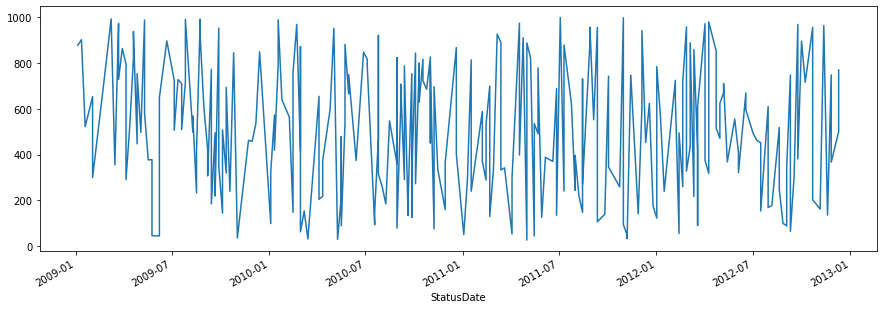

In [16]:
df['CustomerCount'].plot(figsize=(15,5));

In [17]:
sortdf = df[df['State']=='NY'].sort_index(axis=0)
sortdf.head(10)

State  Status  CustomerCount
StatusDate                             
2009-01-19    NY       1            522
2009-02-23    NY       1            710
2009-03-09    NY       1            992
2009-03-16    NY       1            355
2009-03-23    NY       1            728
2009-03-30    NY       1            863
2009-04-13    NY       1            520
2009-04-20    NY       1            820
2009-04-20    NY       1            937
2009-04-27    NY       1            447

Our task is now to create a new dataframe that compresses the data so we have daily customer counts per State and StatusDate. We can ignore the Status column since all the values in this column are of value 1. To accomplish this we will use the dataframe's functions **groupby** and **sum()**.

Note that we had to use **reset_index** . If we did not, we would not have been able to group by both the State and the StatusDate since the groupby function expects only columns as inputs. The **reset_index function** will bring the index StatusDate back to a column in the dataframe.

In [18]:
# Group by State and StatusDate
Daily = df.reset_index().groupby(['State','StatusDate']).sum()
Daily.head()

Status  CustomerCount
State StatusDate                       
FL    2009-01-12       1            901
      2009-02-02       1            653
      2009-03-23       1            752
      2009-04-06       2           1086
      2009-06-08       1            649

In [19]:
#Below we delete the Status column since it is all equal to one and no longer necessary.
del Daily['Status']
Daily.head()

CustomerCount
State StatusDate               
FL    2009-01-12            901
      2009-02-02            653
      2009-03-23            752
      2009-04-06           1086
      2009-06-08            649

In [20]:
# What is the index of the dataframe
Daily.index

MultiIndex([('FL', '2009-01-12'),
            ('FL', '2009-02-02'),
            ('FL', '2009-03-23'),
            ('FL', '2009-04-06'),
            ('FL', '2009-06-08'),
            ('FL', '2009-07-06'),
            ('FL', '2009-07-13'),
            ('FL', '2009-07-20'),
            ('FL', '2009-08-10'),
            ('FL', '2009-08-24'),
            ...
            ('TX', '2012-01-09'),
            ('TX', '2012-02-27'),
            ('TX', '2012-03-12'),
            ('TX', '2012-04-23'),
            ('TX', '2012-04-30'),
            ('TX', '2012-08-06'),
            ('TX', '2012-08-20'),
            ('TX', '2012-08-27'),
            ('TX', '2012-09-03'),
            ('TX', '2012-10-29')],
           names=['State', 'StatusDate'], length=239)

In [21]:
# Select the State index
Daily.index.levels[0]

Index(['FL', 'GA', 'NY', 'TX'], dtype='object', name='State')

In [22]:
# Select the StatusDate index
Daily.index.levels[1]

DatetimeIndex(['2009-01-05', '2009-01-12', '2009-01-19', '2009-02-02',
               '2009-02-23', '2009-03-09', '2009-03-16', '2009-03-23',
               '2009-03-30', '2009-04-06',
               ...
               '2012-09-24', '2012-10-01', '2012-10-08', '2012-10-22',
               '2012-10-29', '2012-11-05', '2012-11-12', '2012-11-19',
               '2012-11-26', '2012-12-10'],
              dtype='datetime64[ns]', name='StatusDate', length=161, freq=None)

Data seems too become cleaner. Let's check this.

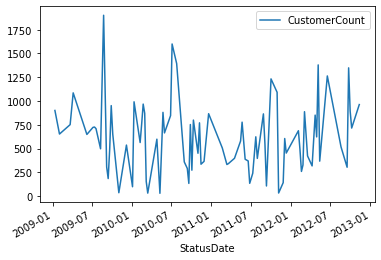

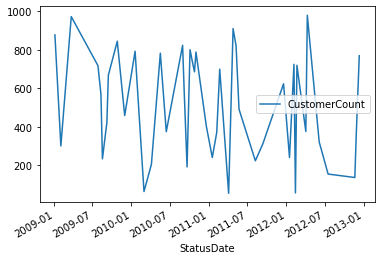

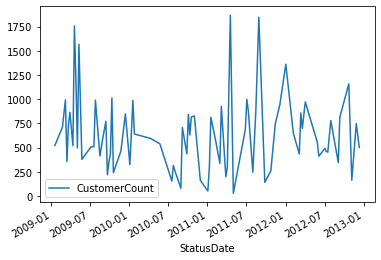

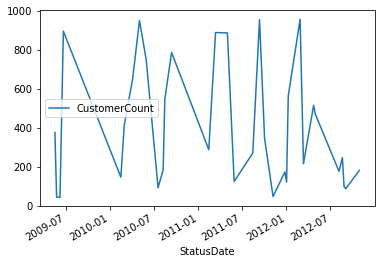

In [23]:
Daily.loc['FL'].plot()
Daily.loc['GA'].plot()
Daily.loc['NY'].plot()
Daily.loc['TX'].plot();



We can also just plot the data on a specific date, like 2012. We can now clearly see that the data for these states is all over the place. since the data consist of weekly customer counts, the variability of the data seems suspect. For this tutorial we will assume bad data and proceed

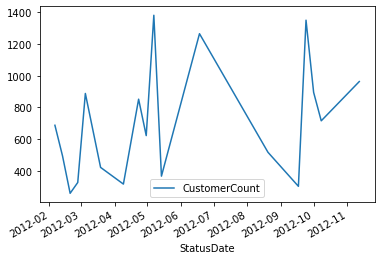

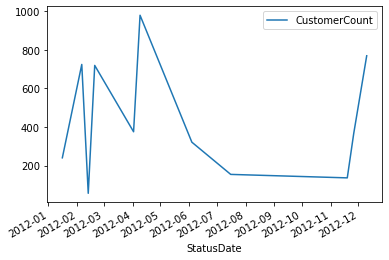

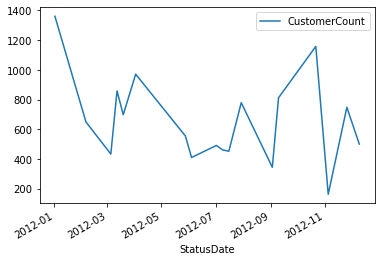

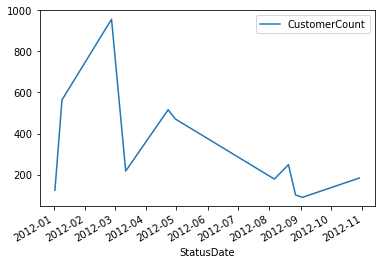

In [24]:
Daily.loc['FL']['2012':].plot()
Daily.loc['GA']['2012':].plot()
Daily.loc['NY']['2012':].plot()
Daily.loc['TX']['2012':].plot();

### Cleaning the data

Literally cutting of everything strange - goes above or under quintiles.


Grouping data in about months because data remain stable in a month.  
**StateYearMonth** - Here we group by State, Year of StatusDate, and Month of StatusDate.
**Daily['Outlier']** - A boolean (True or False) value letting us know if the value in the CustomerCount column is ouside the acceptable range.

Using **transform** instead of **apply** because of data desctidution (graphs are not resembling a gaussian distribution, this means we cannot use summary statistics like the mean and stDev). Transform will keep the shape(# of rows and columns) of the dataframe the same and apply will not.  
**We use percentiles instead of mean or smth like this.** Note that we run the risk of eliminating good data.

In [25]:
# Calculate Outliers
StateYearMonth = Daily.groupby([Daily.index.get_level_values(0), Daily.index.get_level_values(1).year, Daily.index.get_level_values(1).month])
Daily['Lower'] = StateYearMonth['CustomerCount'].transform( lambda x: x.quantile(q=.25) - (1.5*x.quantile(q=.75)-x.quantile(q=.25)) )
Daily['Upper'] = StateYearMonth['CustomerCount'].transform( lambda x: x.quantile(q=.75) + (1.5*x.quantile(q=.75)-x.quantile(q=.25)) )
Daily['Outlier'] = (Daily['CustomerCount'] < Daily['Lower']) | (Daily['CustomerCount'] > Daily['Upper']) 

# Remove Outliers
Daily = Daily[Daily['Outlier'] == False] #жестока

The dataframe named Daily will hold customer counts that have been aggregated per day. The original data (df) has multiple records per day. We are left with a data set that is indexed by both the state and the StatusDate. The Outlier column should be equal to False signifying that the record is not an outlier

In [26]:
Daily.head()

CustomerCount  Lower   Upper  Outlier
State StatusDate                                       
FL    2009-01-12            901  450.5  1351.5    False
      2009-02-02            653  326.5   979.5    False
      2009-03-23            752  376.0  1128.0    False
      2009-04-06           1086  543.0  1629.0    False
      2009-06-08            649  324.5   973.5    False

Creating **new dataframe named ALL** which groups the Daily dataframe by StatusDate. 

In [27]:
# Combine all markets

# Get the max customer count by Date
ALL = pd.DataFrame(Daily['CustomerCount'].groupby(Daily.index.get_level_values(1)).sum())
ALL.columns = ['CustomerCount'] # rename column

# Group by Year and Month
YearMonth = ALL.groupby([lambda x: x.year, lambda x: x.month])

# What is the max customer count per Year and Month
# The Max column represents the maximum customer count per month. 
# The Max column is used to smooth out the graph.
ALL['Max'] = YearMonth['CustomerCount'].transform(lambda x: x.max())
ALL.head()

CustomerCount  Max
StatusDate                    
2009-01-05            877  901
2009-01-12            901  901
2009-01-19            522  901
2009-02-02            953  953
2009-02-23            710  953

Note: If we had used **apply**, we would have got a dataframe with (Year and Month) as the index and just the Max column with the value of 901.

For business analysis purposes checking if we are to rich assigned sales tasks.  
We will call the goals BHAG (Big Hairy Annual Goal).

    12/31/2011 - 1,000 customers
    12/31/2012 - 2,000 customers
    12/31/2013 - 3,000 customers

We will be using the date_range function to create our dates.

**Definition**: date_range(start=None, end=None, periods=None, freq='D', tz=None, normalize=False, name=None, closed=None)  
**Docstring**: Return a fixed frequency datetime index, with day (calendar) as the default frequency

In [28]:
pd.date_range?

In [29]:
# Create the BHAG dataframe
data = [1000,2000,3000]
idx = pd.date_range(start='12/31/2011', end='12/31/2013', freq='A')
BHAG = pd.DataFrame(data, index=idx, columns=['BHAG'])
BHAG

BHAG
2011-12-31  1000
2012-12-31  2000
2013-12-31  3000

In [30]:
# Combine the BHAG and the ALL data set(using the concat for this)
combined = pd.concat([ALL,BHAG], axis=0) 
# when we choose axis = 0 we are appending row wise.
combined = combined.sort_index(axis=0)
combined.tail()

CustomerCount     Max    BHAG
2012-11-19          136.0  1115.0     NaN
2012-11-26         1115.0  1115.0     NaN
2012-12-10         1269.0  1269.0     NaN
2012-12-31            NaN     NaN  2000.0
2013-12-31            NaN     NaN  3000.0

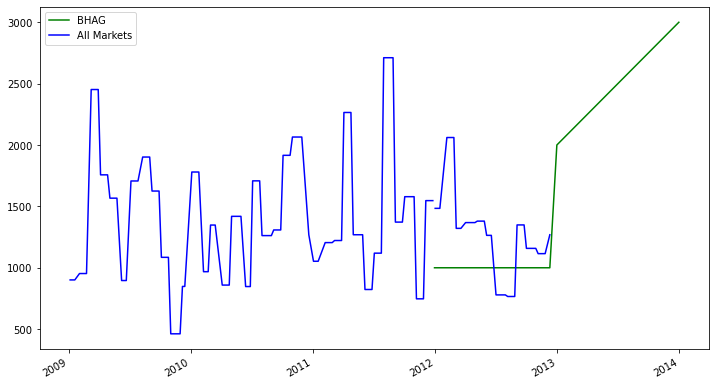

In [31]:
fig, axes = plt.subplots(figsize=(12, 7))

combined['BHAG'].fillna(method='pad').plot(color='green', label='BHAG')
combined['Max'].plot(color='blue', label='All Markets')
plt.legend(loc='best');

There was also a need to forecast next year's customer count and we can do this in a couple of simple steps. We will first group the combined dataframe by Year and place the maximum customer count for that year. This will give us one row per Year.

In [32]:
# Group by Year and then get the max value per year
Year = combined.groupby(lambda x: x.year).max()
Year

CustomerCount     Max    BHAG
2009         2452.0  2452.0     NaN
2010         2065.0  2065.0     NaN
2011         2711.0  2711.0  1000.0
2012         2061.0  2061.0  2000.0
2013            NaN     NaN  3000.0

In [33]:
# Add a column representing the percent change per year
Year['YR_PCT_Change'] = Year['Max'].pct_change(periods=1)
Year

CustomerCount     Max    BHAG  YR_PCT_Change
2009         2452.0  2452.0     NaN            NaN
2010         2065.0  2065.0     NaN      -0.157830
2011         2711.0  2711.0  1000.0       0.312833
2012         2061.0  2061.0  2000.0      -0.239764
2013            NaN     NaN  3000.0       0.000000

Making a prediction for the next year assuming our current growth rate remains constant

In [34]:
(1 + Year.loc[2012,'YR_PCT_Change']) * Year.loc[2012,'Max']

1566.8465510881595

# Present Data

Create individual Graphs per State.

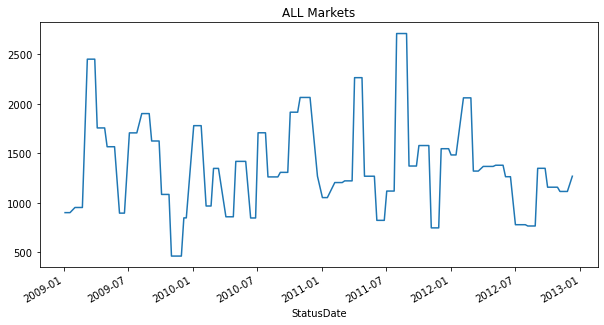

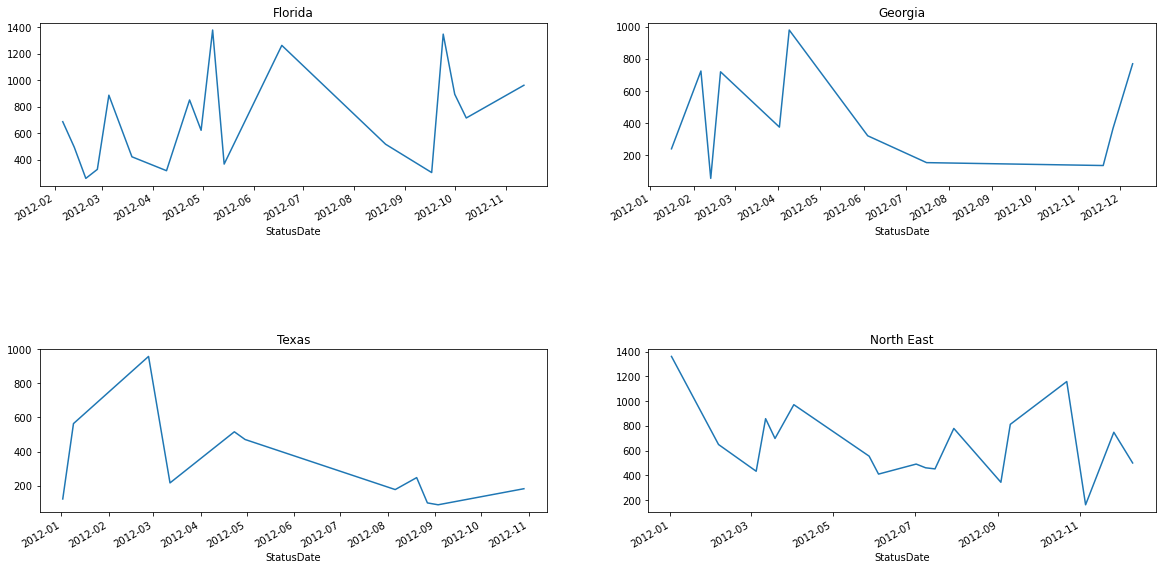

In [37]:
# First Graph
ALL['Max'].plot(figsize=(10, 5));plt.title('ALL Markets')
# Last four Graphs
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.subplots_adjust(hspace=1.0) ## Create space between plots

Daily.loc['FL']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[0,0])
Daily.loc['GA']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[0,1]) 
Daily.loc['TX']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[1,0]) 
Daily.loc['NY']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[1,1]) 

# Add titles
axes[0,0].set_title('Florida')
axes[0,1].set_title('Georgia')
axes[1,0].set_title('Texas')
axes[1,1].set_title('North East');